In [35]:
import sys
import os
from IPython.display import Image, display
from pprint import pprint
   
# Add the project root directory to Python's module search path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

In [2]:
# import graph
from src.models.graph import GraphBuilder, decide_mood, START, END

# Usage example:
builder = GraphBuilder()

# Add nodes
builder.add_node("node_1", "This")
builder.add_node("node_2", "is")
builder.add_node("node_3", "really")
builder.add_node("node_4", "awesome")
builder.add_node("node_5", "bad")

# Add edges
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_conditional_edge("node_3", decide_mood)
builder.add_edge("node_4", END)
builder.add_edge("node_5", END)

graph = builder.build()

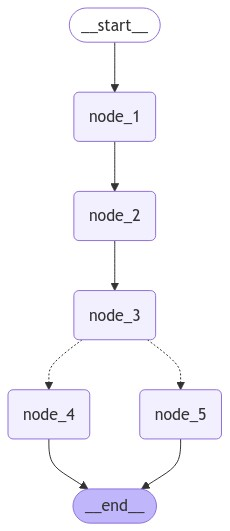

In [3]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

------node_1------
------node_2------
------node_3------
------node_4------


{'graph_state': 'Hi, this is Lance. This is really awesome'}

In [13]:
# get groq provider
from src.services.providers import AIProviderType, AIProviderFactory

llm = AIProviderFactory.create_provider(AIProviderType.GROQ, "llama-3.1-8b-instant")

In [14]:
result = llm.invoke("what is a quadrilateral?")
print(result.content)

A quadrilateral is a two-dimensional shape with four sides. It is a polygon with four vertices (corners) and four edges (sides). The sum of the interior angles of a quadrilateral is always 360 degrees.

There are several types of quadrilaterals, including:

1. **Rectangle**: A quadrilateral with four right angles (90-degree angles) and opposite sides that are equal in length.
2. **Square**: A quadrilateral with four right angles (90-degree angles) and all sides that are equal in length.
3. **Rhombus**: A quadrilateral with all sides of equal length and opposite angles that are equal.
4. **Trapezoid**: A quadrilateral with two pairs of sides where one pair is parallel.
5. **Kite**: A quadrilateral with two pairs of adjacent sides where one pair is equal in length.
6. **Parallelogram**: A quadrilateral with opposite sides that are parallel.

Quadrilaterals are an important concept in geometry and are used in many real-world applications, such as architecture, engineering, and design.


In [12]:
result.response_metadata

{'token_usage': {'completion_tokens': 296,
  'prompt_tokens': 41,
  'total_tokens': 337,
  'completion_time': 0.394666667,
  'prompt_time': 0.008377685,
  'queue_time': 0.006048294000000001,
  'total_time': 0.403044352},
 'model_name': 'llama-3.1-8b-instant',
 'system_fingerprint': 'fp_f66ccb39ec',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

In [40]:
def multiply(a: int, b: int) -> int:
    """
    Multiplies a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """
    Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """
    Subtracts b from a.

    Args:
        a: first int
        b: second int
    """
    return a - b

llm_with_tools = llm.bind_tools([multiply, add, subtract])

In [41]:
from langchain_core.messages import HumanMessage, AIMessage

tool_call = llm_with_tools.invoke([HumanMessage(content="what is four minus 1?",name="Monty")])
print(tool_call)

content='' additional_kwargs={'tool_calls': [{'id': 'call_nzr4', 'function': {'arguments': '{"a": 4, "b": 1}', 'name': 'subtract'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 361, 'total_tokens': 380, 'completion_time': 0.025333333, 'prompt_time': 0.073952907, 'queue_time': 0.002323583000000004, 'total_time': 0.09928624}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-76669516-f3f7-4876-99e8-9f8ea44c3c6e-0' tool_calls=[{'name': 'subtract', 'args': {'a': 4, 'b': 1}, 'id': 'call_nzr4', 'type': 'tool_call'}] usage_metadata={'input_tokens': 361, 'output_tokens': 19, 'total_tokens': 380}


In [42]:
tool_call.additional_kwargs['tool_calls']


[{'id': 'call_nzr4',
  'function': {'arguments': '{"a": 4, "b": 1}', 'name': 'subtract'},
  'type': 'function'}]

In [43]:
from langgraph.graph.message import add_messages


initial_message = [AIMessage(content="Hi, How can I assist you today?"),
                   HumanMessage(content="I need help with math", name="Monty")]

new_message = AIMessage(content="Sure, I can help you with that. What do you need help with?",name="Model")
add_messages(initial_message, new_message)

[AIMessage(content='Hi, How can I assist you today?', additional_kwargs={}, response_metadata={}, id='a21086e2-bcdc-49fb-ab07-c232214114ee'),
 HumanMessage(content='I need help with math', additional_kwargs={}, response_metadata={}, name='Monty', id='8500fdcb-4656-4942-bf8a-850dcde6932e'),
 AIMessage(content='Sure, I can help you with that. What do you need help with?', additional_kwargs={}, response_metadata={}, name='Model', id='f3c512a1-966b-4769-9a99-c8bdaf533e93')]

### Graph with tools calling



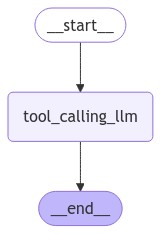

In [44]:
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END, MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

# Node for tool calling
def tool_calling_llm(state: MessagesState):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [45]:
# Test with Random messages
messages = graph.invoke({"messages": HumanMessage(content="Hello")})
for message in messages["messages"]:
    message.pretty_print()  


================================ Human Message =================================

Hello
================================== Ai Message ==================================

I'm happy to chat with you. What would you like to talk about or ask about?


In [46]:
# Test with Math Problem
messages = graph.invoke({"messages": HumanMessage(content="What is 2 - 2?")})
for message in messages["messages"]:
    message.pretty_print()  




================================ Human Message =================================

What is 2 - 2?
================================== Ai Message ==================================
Tool Calls:
  subtract (call_gaph)
 Call ID: call_gaph
  Args:
    a: 2
    b: 2


### Router

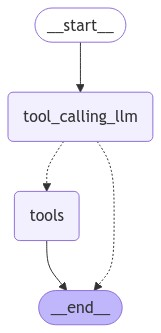

In [48]:
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply, add, subtract]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
# Test with Random messages
messages = graph.invoke({"messages": HumanMessage(content="Hello")})
for message in messages["messages"]:
    message.pretty_print()  

================================ Human Message =================================

Hello
================================== Ai Message ==================================

I'm happy to chat with you. What would you like to talk about or is there something specific you need help with?


In [55]:
# Test with Math Problem
messages = graph.invoke({"messages": HumanMessage(content="What is 5 plus 2?")})
for message in messages["messages"]:
    message.pretty_print()  


================================ Human Message =================================

What is 5 plus 2?
================================== Ai Message ==================================
Tool Calls:
  add (call_7k6m)
 Call ID: call_7k6m
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: add

7
